# Importing Libraries

In [57]:
import numpy as np     
import pandas as pd    
from pandas.plotting import autocorrelation_plot as auto_corr

import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sbn

import math
from datetime import datetime
from datetime import timedelta

import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor 
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import preprocessing
from sklearn import svm

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

# Loading with data

In [58]:
pd.options.display.max_columns = 100

In [59]:
features_data = pd.read_csv('features.csv')
stores_data = pd.read_csv('stores.csv')
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [60]:
stores_data.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [61]:
train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [62]:
features_data.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


# Understanding the data

In [63]:
#Merging the datasets
data = train_data.merge(features_data, on=['Store', 'Date'], how='inner').merge(stores_data, on=['Store'], how='inner')
data.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [64]:
#Deleting the duplicate columns
data.drop(['IsHoliday_y'], axis=1, inplace=True)

In [65]:
data.rename(columns={'IsHoliday_x':'IsHoliday'}, inplace=True)
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [66]:
data.shape

(421570, 16)

# Store & Department Numbers

In [67]:
#Number of unique stores
data['Store'].nunique() 

45

In [68]:
#No. of unique departments
data['Dept'].nunique()

81

In [69]:
#Finding the outliers in the average weekly sales 
store_dept_table = pd.pivot_table(data, index='Store', columns='Dept', values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,8

In [70]:
data.loc[data['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


In [71]:
data = data.loc[data['Weekly_Sales'] > 0]

In [72]:
data.shape

(420212, 16)

# Peeking into the "Date" column

In [73]:
head = data['Date'].head()
tail = data['Date'].tail()
combined = pd.concat([head, tail])

combined

0         2010-02-05
1         2010-02-05
2         2010-02-05
3         2010-02-05
4         2010-02-05
421565    2012-10-26
421566    2012-10-26
421567    2012-10-26
421568    2012-10-26
421569    2012-10-26
Name: Date, dtype: object

# Peeking into the "IsHoliday" column

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

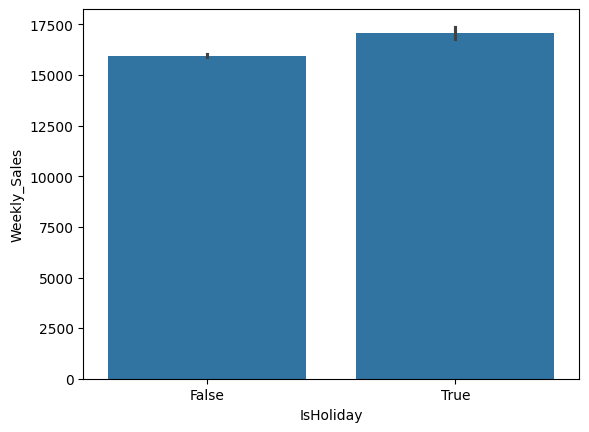

In [74]:
sbn.barplot(x='IsHoliday', y='Weekly_Sales', data=data)

In [75]:
#Checking the holiday dates
data_holiday = data.loc[data['IsHoliday']==True]
data_holiday['Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [76]:
#Checking the non-holiday dates
data_not_holiday = data.loc[data['IsHoliday']==False]
data_not_holiday['Date'].nunique()

133

In [77]:
#Column for Super Bowling holiday
data.loc[(data['Date']=='2010-02-12') | (data['Date']=='2011-02-11') | (data['Date']=='2012-02-10'), 'Super_Bowl'] = True
data.loc[(data['Date']!='2010-02-12') & (data['Date']!='2011-02-11') & (data['Date']!='2012-02-10'), 'Super_Bowl'] = False

In [78]:
#Column for Labor holiday
data.loc[(data['Date']=='2010-09-10') | (data['Date']=='2011-09-09') | (data['Date']=='2012-09-07'), 'Labor_Day'] = True
data.loc[(data['Date']!='2010-09-10') & (data['Date']!='2011-09-09') & (data['Date']!='2012-09-07'), 'Labor_Day'] = False

In [79]:
#Column for Thanksgiving holiday
data.loc[(data['Date']=='2010-11-26') | (data['Date']=='2011-11-25'), 'Thanksgiving'] = True
data.loc[(data['Date']!='2010-11-26') & (data['Date']!='2011-11-25'), 'Thanksgiving'] = False

In [80]:
#Column for Christmas holiday
data.loc[(data['Date']=='2010-12-31') | (data['Date']=='2011-02-11') | (data['Date']=='2010-02-10'), 'Christmas'] = True
data.loc[(data['Date']!='2010-12-31') & (data['Date']!='2011-02-11') & (data['Date']!='2010-02-10'), 'Christmas'] = False

<Axes: xlabel='Super_Bowl', ylabel='Weekly_Sales'>

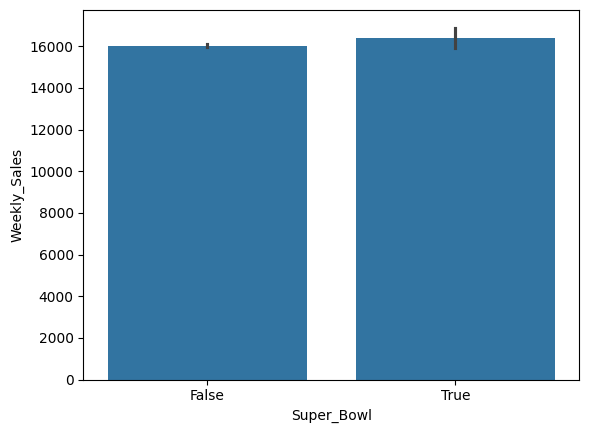

In [81]:
sbn.barplot(x='Super_Bowl', y='Weekly_Sales', data=data)

<Axes: xlabel='Labor_Day', ylabel='Weekly_Sales'>

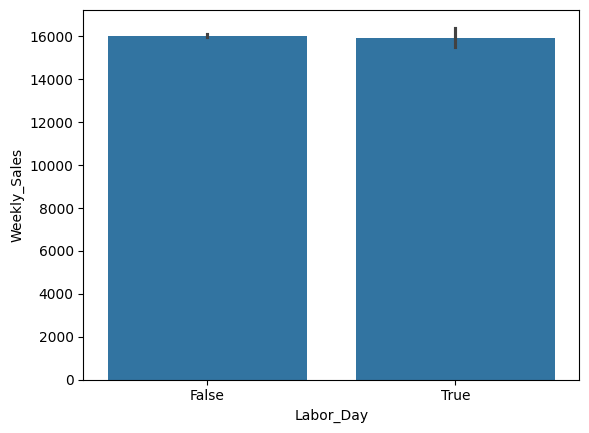

In [82]:
sbn.barplot(x='Labor_Day', y='Weekly_Sales', data=data)

<Axes: xlabel='Thanksgiving', ylabel='Weekly_Sales'>

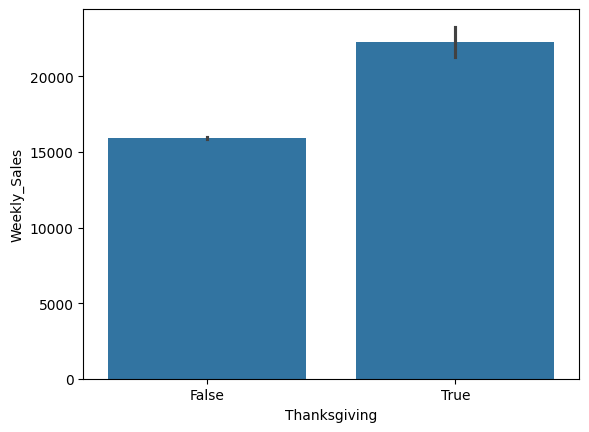

In [83]:
sbn.barplot(x='Thanksgiving', y='Weekly_Sales', data=data)

<Axes: xlabel='Christmas', ylabel='Weekly_Sales'>

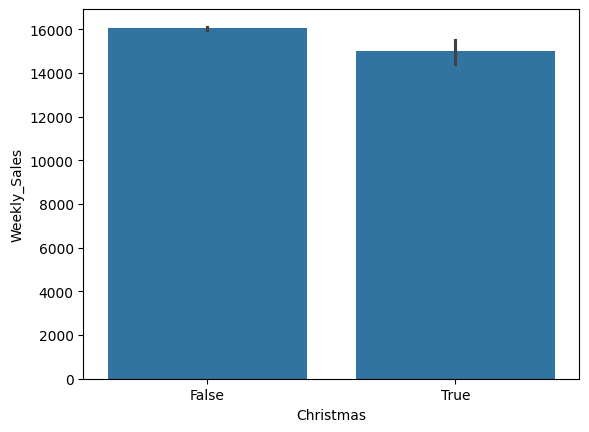

In [84]:
sbn.barplot(x='Christmas', y='Weekly_Sales', data=data)

# Type Effect on Holiday

In [85]:
data.groupby(['Super_Bowl', 'Type'])['Weekly_Sales'].mean()

Super_Bowl  Type
False       A       20138.055908
            B       12286.739293
            C        9536.110508
True        A       20612.757674
            B       12467.035506
            C       10179.271884
Name: Weekly_Sales, dtype: float64

In [86]:
data.groupby(['Labor_Day', 'Type'])['Weekly_Sales'].mean()

Labor_Day  Type
False      A       20151.210941
           B       12294.954138
           C        9542.098293
True       A       20004.267422
           B       12084.304642
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [87]:
data.groupby(['Thanksgiving', 'Type'])['Weekly_Sales'].mean()

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [88]:
data.groupby(['Christmas', 'Type'])['Weekly_Sales'].mean()

Christmas  Type
False      A       20167.193936
           B       12303.056074
           C        9553.534521
True       A       18802.357921
           B       11407.743487
           C        9251.673728
Name: Weekly_Sales, dtype: float64

In [89]:
data.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15952.816352
True     17094.300918
Name: Weekly_Sales, dtype: float64

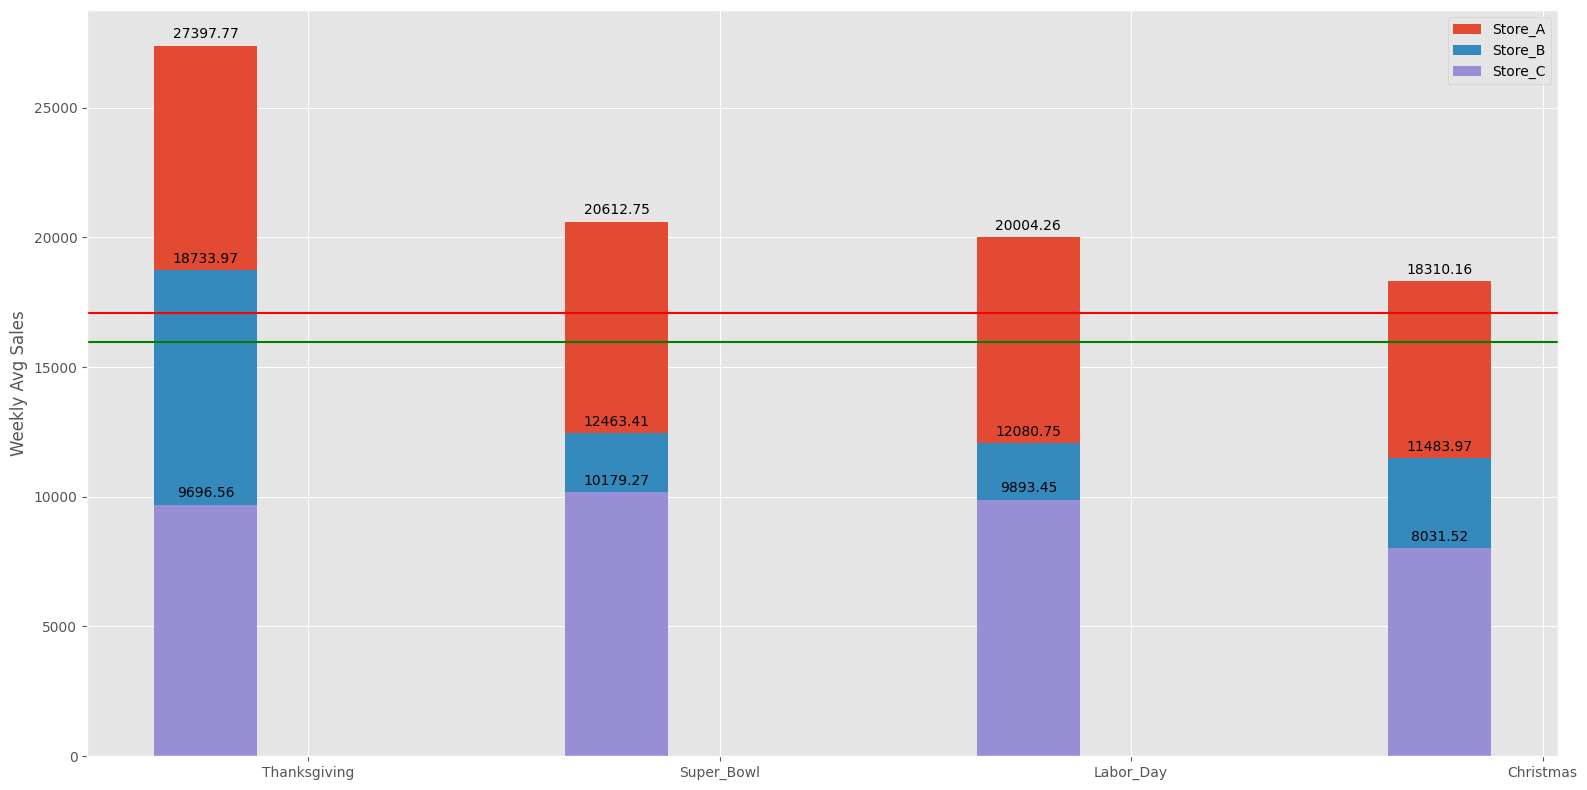

In [90]:
#Plotting avg weekly sales according to holidays by types
plt.style.use('ggplot')
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_mean = [27397.77, 20612.75, 20004.26, 18310.16]
B_mean = [18733.97, 12463.41, 12080.75, 11483.97]
C_mean = [9696.56,10179.27,9893.45,8031.52]

x = np.arange(len(labels))
width = 0.25
fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_mean, width, label='Store_A')
rects2 = ax.bar(x - width, B_mean, width, label='Store_B')
rects3 = ax.bar(x - width, C_mean, width, label='Store_C')
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height), xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') #Holiday Avg
plt.axhline(y=15952.82,color='green') #Non-Holiday Avg
fig.tight_layout()
plt.show()

In [91]:
data.sort_values(by='Weekly_Sales', ascending=False).head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
90645,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,False,False,True,False
337053,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,False,False,True,False
94393,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,False,False,True,False
333594,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,False,False,True,False
131088,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,False,False,True,False


# Markdown column

In [92]:
data.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270031
MarkDown2       309308
MarkDown3       283561
MarkDown4       285694
MarkDown5       269283
CPI                  0
Unemployment         0
Type                 0
Size                 0
Super_Bowl           0
Labor_Day            0
Thanksgiving         0
Christmas            0
dtype: int64

In [93]:
data = data.fillna(0)

In [94]:
data.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super_Bowl      0
Labor_Day       0
Thanksgiving    0
Christmas       0
dtype: int64

In [95]:
data.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


# Visualizations for Sales

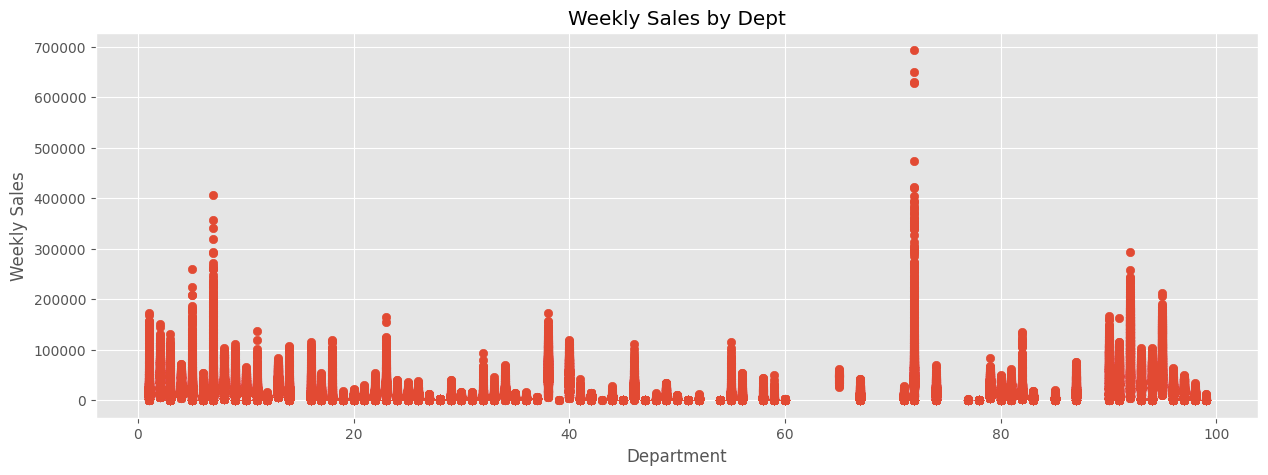

In [96]:
x = data['Dept']
y = data['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Dept')
plt.xlabel('Department')
plt.ylabel('Weekly Sales')
plt.scatter(x, y)
plt.show()

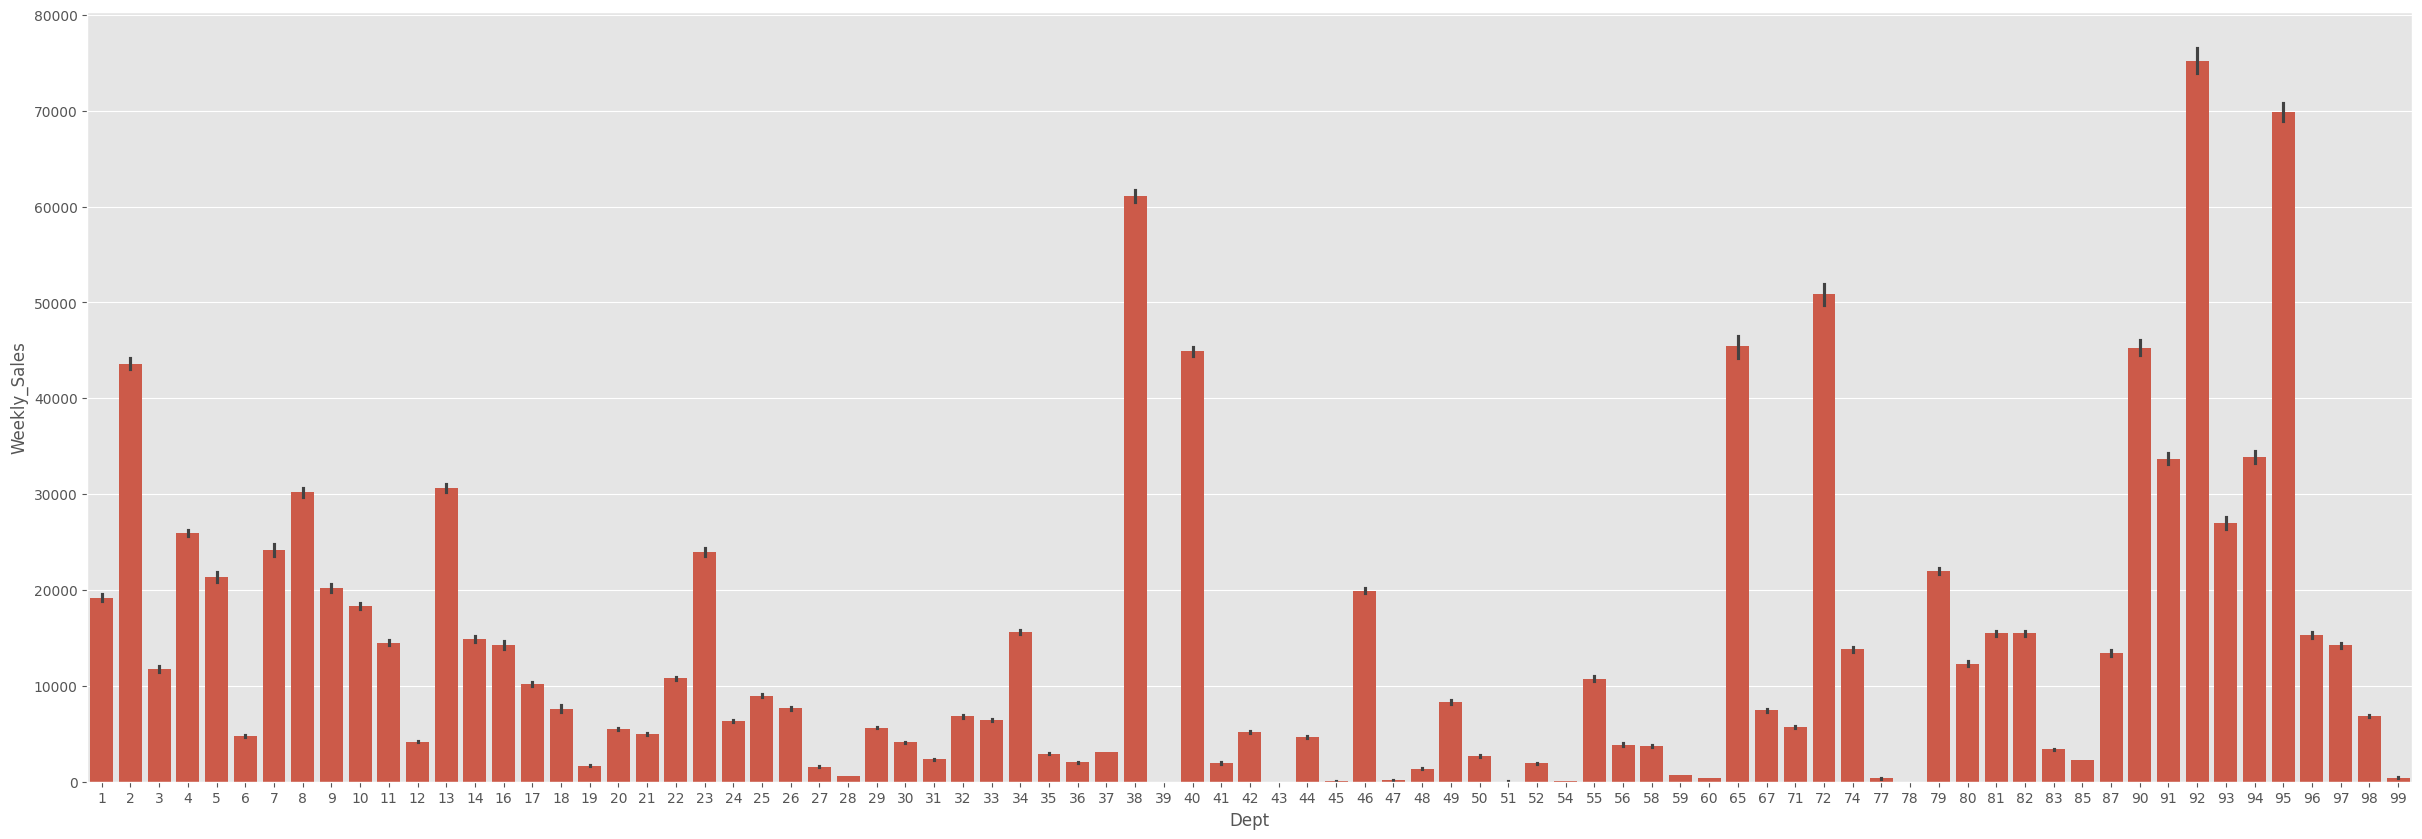

In [97]:
plt.figure(figsize=(30,10))
fig = sbn.barplot(x='Dept', y='Weekly_Sales', data=data)

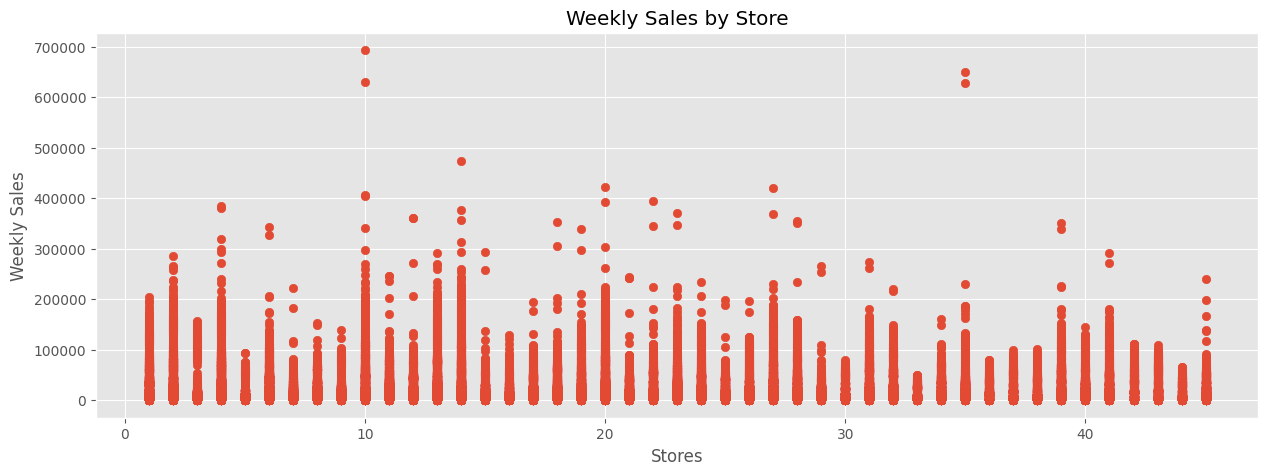

In [98]:
x = data['Store']
y = data['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

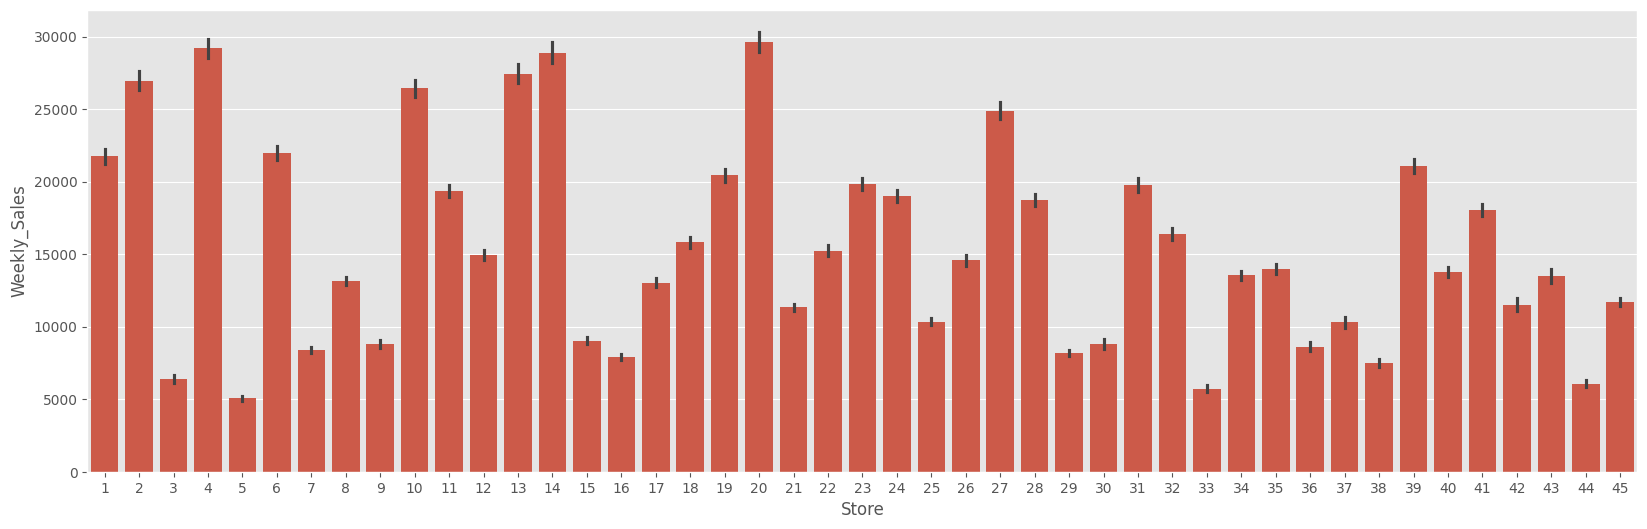

In [99]:
plt.figure(figsize=(20,6))
fig = sbn.barplot(x='Store', y='Weekly_Sales', data=data)

# Handling the Date Column

In [101]:
data['Date'] = pd.to_datetime(data['Date'])
data['Week'] = data['Date'].dt.isocalendar().week
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

In [102]:
data.groupby('Month')['Weekly_Sales'].mean()

Month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [103]:
data.groupby('Year')['Weekly_Sales'].mean()

Year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='Month'>

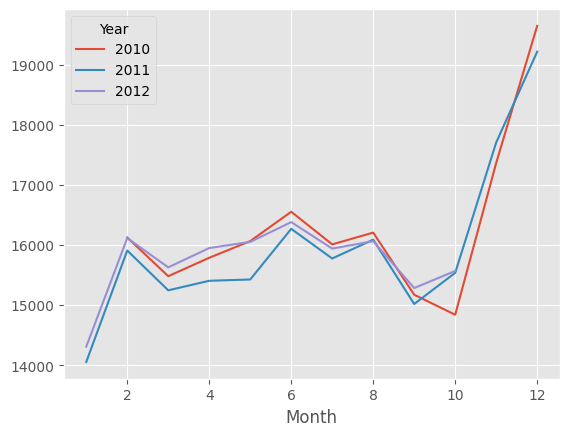

In [104]:
monthly_sales = pd.pivot_table(data, values='Weekly_Sales', columns='Year', index='Month')
monthly_sales.plot()

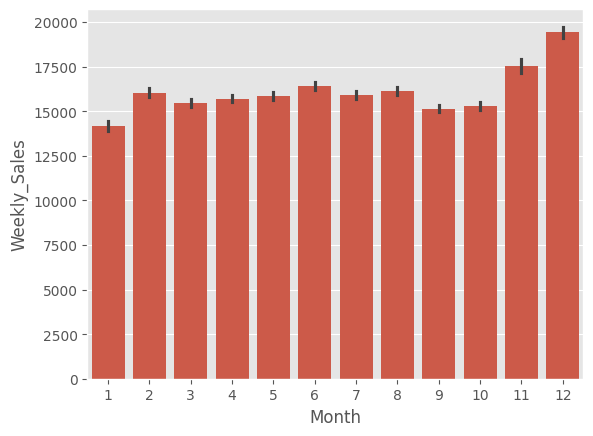

In [105]:
fig = sbn.barplot(x='Month', y='Weekly_Sales', data=data)

In [106]:
data.groupby('Week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

Week
51    26454.164116
47    22269.601768
50    20478.421134
49    18731.794840
22    16856.650245
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='Week'>

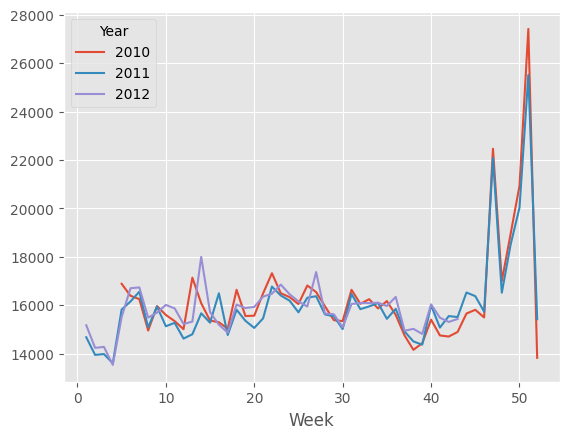

In [107]:
weekly_sales = pd.pivot_table(data, values='Weekly_Sales', columns='Year', index='Week')
weekly_sales.plot()

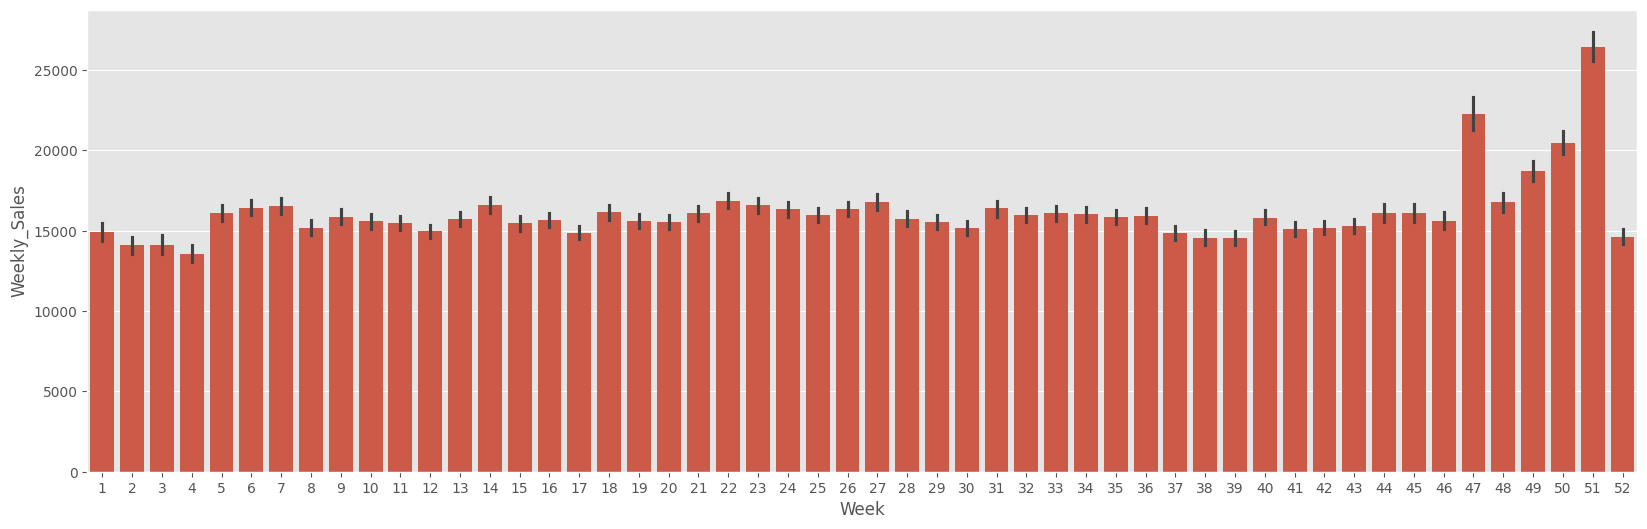

In [108]:
plt.figure(figsize=(20,6))
fig = sbn.barplot(x='Week', y='Weekly_Sales', data=data)

# Fuel Price, CPI, Unemployement, Temperature Effects

<Axes: xlabel='Fuel_Price'>

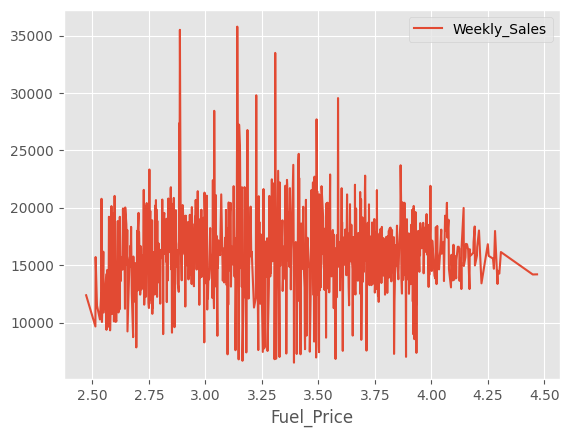

In [109]:
feul_price = pd.pivot_table(data, values='Weekly_Sales', index='Fuel_Price')
feul_price.plot()

<Axes: xlabel='Temperature'>

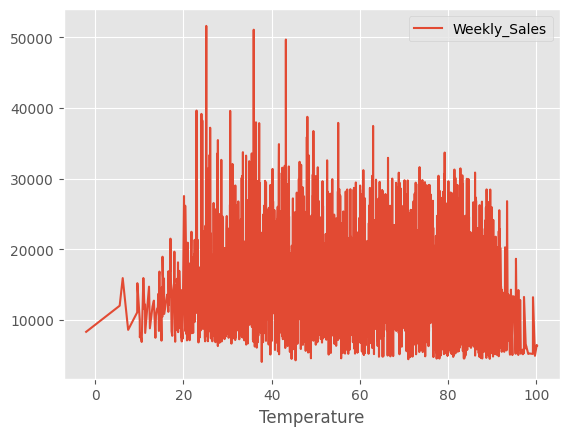

In [110]:
temp = pd.pivot_table(data, values='Weekly_Sales', index='Temperature')
temp.plot()

<Axes: xlabel='CPI'>

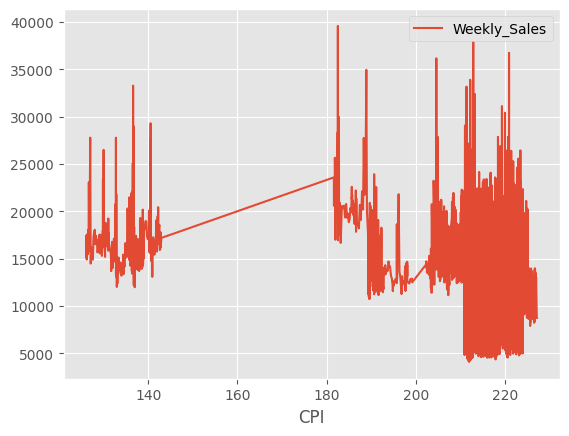

In [111]:
cpi = pd.pivot_table(data, values='Weekly_Sales', index='CPI')
cpi.plot()

<Axes: xlabel='Unemployment'>

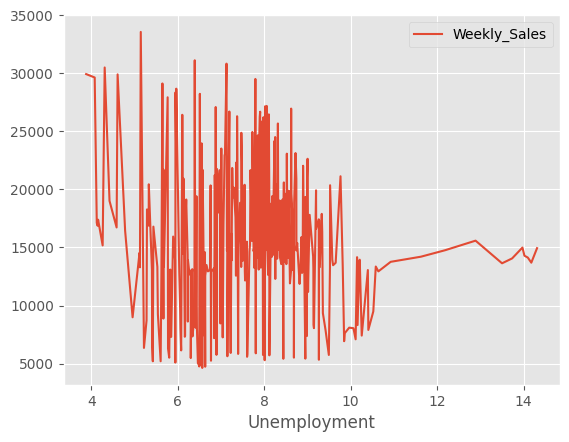

In [112]:
unemp = pd.pivot_table(data, values='Weekly_Sales', index='Unemployment')
unemp.plot()

# Encoding

In [113]:
data_encoded = data.copy()
type_group = {'A':1, 'B':2, 'C':3}
data_encoded['Type'] = data_encoded['Type'].replace(type_group)

In [114]:
data_encoded['Super_Bowl'] = data_encoded['Super_Bowl'].astype(bool).astype(int)
data_encoded['Thanksgiving'] = data_encoded['Thanksgiving'].astype(bool).astype(int)
data_encoded['Labor_Day'] = data_encoded['Labor_Day'].astype(bool).astype(int)
data_encoded['Christmas'] = data_encoded['Christmas'].astype(bool).astype(int)
data_encoded['IsHoliday'] = data_encoded['IsHoliday'].astype(bool).astype(int)

# Correlation 

In [115]:
drop_col = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas']
data_encoded.drop(drop_col, axis=1, inplace=True)

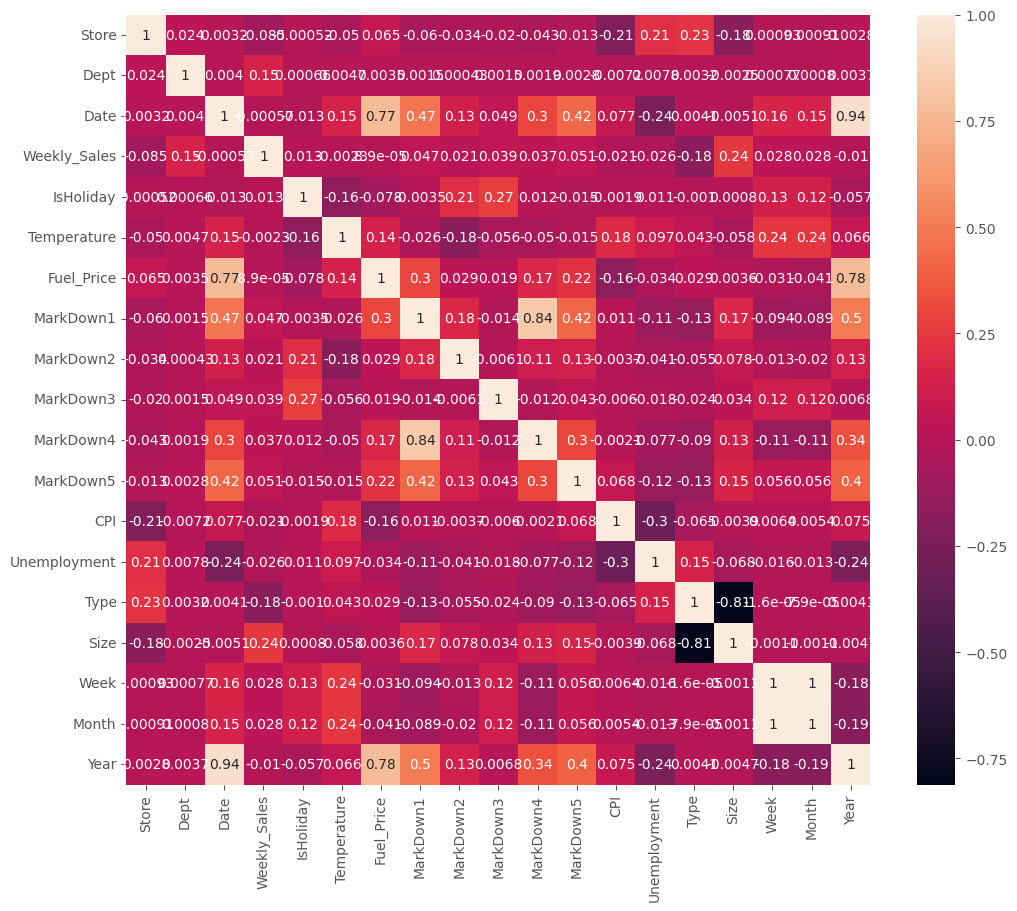

In [117]:
plt.figure(figsize=(12,10))
sbn.heatmap(data_encoded.corr(),annot=True)
plt.show()

In [118]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
data_encoded.drop(drop_col, axis=1, inplace=True)

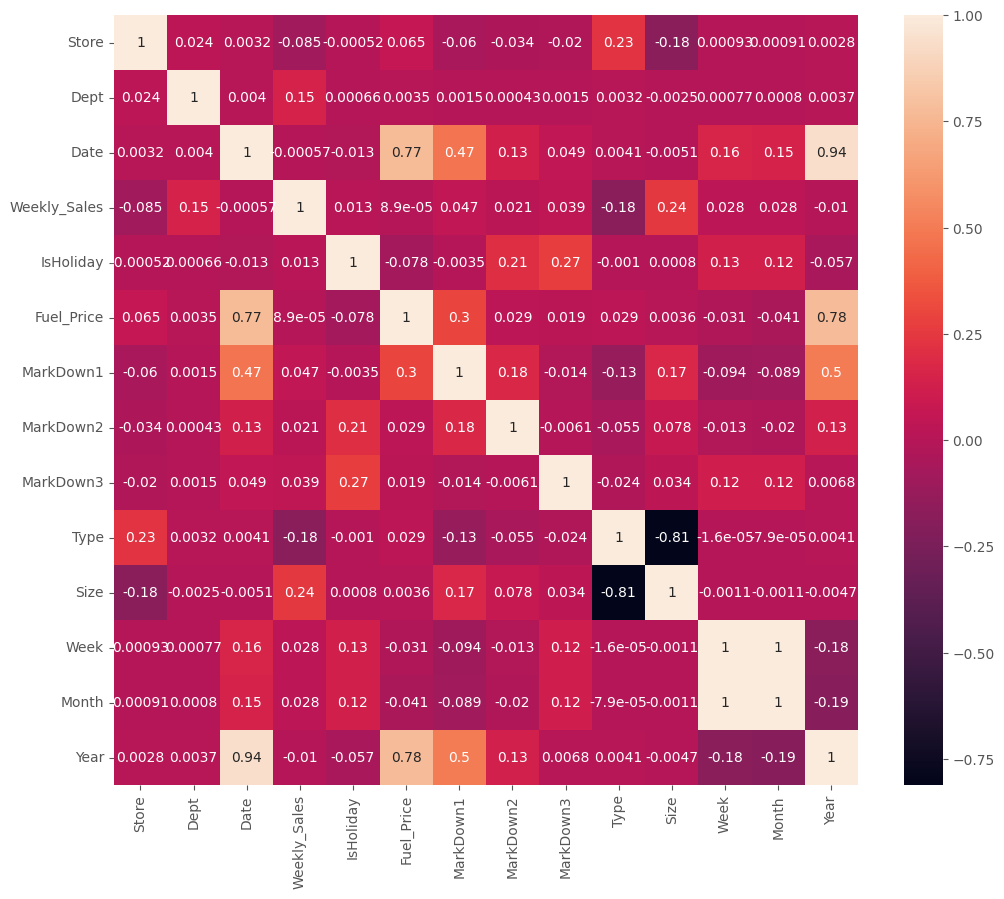

In [120]:
plt.figure(figsize=(12,10))
sbn.heatmap(data_encoded.corr(),annot=True)
plt.show()

In [121]:
data_encoded = data_encoded.sort_values(by='Date', ascending=True)

# Linear Regression

In [122]:
data_encoded_train = data_encoded[:int(0.7*(len(data_encoded)))]
data_encoded_test = data_encoded[int(0.7*(len(data_encoded))):]
target = 'Weekly_Sales'
used_cols = [c for c in data_encoded.columns.to_list() if c not in [target]]
x_train = data_encoded_train[used_cols]
x_test = data_encoded_test[used_cols]
y_train = data_encoded_train[target]
y_test = data_encoded_test[target]

In [123]:
x_train = x_train.drop(['Date'], axis=1)
x_test = x_test.drop(['Date'], axis=1)

In [124]:
lr = LinearRegression()

In [125]:
lr.fit(x_train, y_train)

LinearRegression()

In [126]:
lr.score(x_test, y_test)*100

8.892519308314572

# kNN 

In [127]:
knn_r = KNeighborsRegressor(n_neighbors = 7)

In [128]:
knn_r.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=7)

In [129]:
knn_r.score(x_test, y_test)*100

32.9177935532334